In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pickle

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter
# import data_creation_pipeline as dcp
# import compute_biased_pks_fields as cpk

%load_ext autoreload
%autoreload 2

2024-08-16 13:12:05.957609: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 13:12:06.201497: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 13:12:06.203192: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 13:12:09.352402: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-16 13:12:14.471872: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [3]:
idx_LH_str = '0663'
sim_name_quijote = f'quijote_LH{idx_LH_str}'

dir_data = '/cosmos_storage/home/mpelle/Yin_data/Quijote'
fn_params = f'{dir_data}/LH{idx_LH_str}/param_{idx_LH_str}.txt'
param_vals = np.loadtxt(fn_params)
param_names = ['omega_m', 'omega_baryon', 'h', 'n_s', 'sigma_8']
param_dict = dict(zip(param_names, param_vals))
cosmo_quijote = utils.get_cosmo(param_dict)

Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value


In [4]:
box_size = 1000.
n_grid = 512

In [67]:
ngenic_phases = True
phase_type = 1

seed = int(idx_LH_str)
expfactor = 1.0
FixedInitialAmplitude = False

sim, disp_fromlpt = bacco.utils.create_lpt_simulation(cosmo_quijote, box_size, Nmesh=n_grid, Seed=seed,
                                                    FixedInitialAmplitude=FixedInitialAmplitude,InitialPhase=0, 
                                                    expfactor=expfactor, LPT_order=2, order_by_order=None,
                                                    phase_type=phase_type, ngenic_phases=ngenic_phases, return_disp=True, 
                                                    sphere_mode=0)

2024-08-16 17:04:30,291 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2024-08-16 17:04:30,292 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
2024-08-16 17:04:30,292 bacco.sims : Initialising simulation Default
2024-08-16 17:04:30,293 bacco.sims : ...done in 0.00113 s


bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler: Computing 2LPT density...
l2=7.78209e-18 
l2=6.73432e-17 
l2=-3.85992e-17 
l2=-3.25662e-18 
l2=-4.83533e-17 
l2=-1.04182e-16 
bacco.lss_scaler: Fourier transforming second order source...
l2=-2.14218e-08 l3a=3.10621e-08 l3b=4.35151e-08


2024-08-16 17:05:01,122 bacco.scaler : Adding displacement field with a vel-factor=53.391221


bacco.lss_scaler:  Adding LSS displacement: vel_factor=53.391221 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [68]:
dens_lin_fromlpt = sim.get_linear_field(ngrid=n_grid, quantity='delta')

bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


### Try with the lagrangian indices

In [7]:
idx_LH = '663'
fn_lag_index = f"/cosmos_storage/data_sharing/quijote_{idx_LH}_neighfile.pickle"
with open(fn_lag_index, 'rb') as f:
    lag_index = pickle.load(f)
print(lag_index.shape)

(134217728,)


In [53]:
idx_LH = '663'
fn_lag_index_ics = f"/cosmos_storage/data_sharing/quijote_ics_{idx_LH}_neighfile.pickle"
with open(fn_lag_index_ics, 'rb') as f:
    lag_index_ics = pickle.load(f)
print(lag_index_ics.shape)

(134217728,)


In [69]:
# putting lag_index as indices here doesn't do anything
bmodel = bacco.BiasModel(sim=None, linear_delta=dens_lin_fromlpt, ngrid=n_grid, ngrid1=None,
                        sdm=False, mode="dm", # these are the defaults - but do we need to change for bacco?
                        BoxSize=box_size,
                        npart_for_fake_sim=n_grid, #damping_scale=damping_scale,
                        bias_model='expansion', deposit_method="cic",
                        use_displacement_of_nn=False, interlacing=False,
                        )

2024-08-16 17:06:09,191 bacco.BiasModel : Initialising Bias Model class ...


In [70]:
lin_field = bmodel.linear_field

2024-08-16 17:06:16,946 bacco.BiasModel : Computing linear field ...
2024-08-16 17:06:16,948 bacco.BiasModel : Memory used: 46.424272896 Gigabytes


### Get pos various ways

In [14]:
fn_disp = f'{dir_data}/LH{idx_LH_str}/dis_{idx_LH_str}.npy'
disp = np.load(fn_disp) # sim
n_grid = disp.shape[-1]

grid = bacco.visualization.uniform_grid(npix=n_grid, L=box_size, ndim=3, bounds=False)

pos = bacco.scaler.add_displacement(None,
                                disp,
                                box=box_size,
                                pos=grid.reshape(-1,3),
                                vel=None,
                                vel_factor=0,
                                verbose=False)[0]

In [15]:
import readgadget

snapshot = '/dipc/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/663/snapdir_004/snap_004'
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

# read positions, velocities and IDs of the particles
pos_raw = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
ids = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0

In [16]:
# ics
snapshot_ics = '/dipc/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/663/ICs/ics'
ids_ics = readgadget.read_block(snapshot_ics, "ID  ", ptype)-1   #IDs starting from 0
pos_raword = pos_raw[ids_ics]

In [56]:
pos_raw_lagind = pos_raw[lag_index]

In [18]:
bias_term_eul_delta = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos, 
                                #mass = (bias_fields_lagind[1]).flatten(), 
                                mass = lin_field.flatten(),
                                deposit_method='cic', 
                                interlacing=False)

2024-08-16 13:25:33,176 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-16 13:25:33,573 bacco.statistics : starting deposit 1


here
3.0819407
134217728
bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb


2024-08-16 13:25:34,518 bacco.statistics :  mesh done in 1.34 s


bacco.mesh : binning of 134217728 particles (134217728 with mass)


In [71]:
bias_term_eul_delta_raw_lagind = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, 
                                                               pos=pos_raw_lagind, 
                                                                mass = lin_field.flatten(), 
                                                                deposit_method='cic', 
                                                                interlacing=False)

2024-08-16 17:07:28,037 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-16 17:07:28,489 bacco.statistics : starting deposit 1
2024-08-16 17:07:29,682 bacco.statistics :  mesh done in 1.65 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


### Measure Pks

In [72]:
norm=n_grid**3
normalise_grid = False
deconvolve_grid = True
k_min = 0.01
k_max = 0.68
n_bins = 30
log_binning = True
correct_grid = True

args_power = {
                'interlacing':False,
                'kmin':k_min,
                'kmax':k_max,
                'nbins':n_bins,
                'log_binning':log_binning,
                'deposit_method':'cic',
                'correct_grid': correct_grid,
                'compute_correlation':False,
                'zspace':False, #we include the velocities before
                'compute_power2d':False}

In [73]:
pairs = [[dens_lin_fromlpt, dens_lin_fromlpt], 
         [bias_term_eul_delta, bias_term_eul_delta],
         [dens_lin_fromlpt, bias_term_eul_delta]]
pk_objs_lagind = []
for pair in pairs:
    pk_obj = bacco.statistics.compute_crossspectrum_twogrids(
                            grid1=pair[0]/norm,
                            grid2=pair[1]/norm,
                            cosmology=cosmo_quijote,
                            ngrid=n_grid,
                            box=box_size,
                            normalise_grid1=normalise_grid,
                            normalise_grid2=normalise_grid,
                            deconvolve_grid1=deconvolve_grid,
                            deconvolve_grid2=deconvolve_grid,
                            **args_power)
    pk_objs_lagind.append(pk_obj)

2024-08-16 17:08:12,031 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.01429e-11 (grid1) -1.01429e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.382394 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.367216 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000148 secs
bacco.power : Deallocating arrays


2024-08-16 17:08:18,906 bacco.statistics :  ...done in 6.87 s
2024-08-16 17:08:20,920 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -3.92072e-10 (grid1) -3.92072e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.467955 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.354478 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000146 secs
bacco.power : Deallocating arrays


2024-08-16 17:08:27,444 bacco.statistics :  ...done in 6.52 s
2024-08-16 17:08:29,176 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.01429e-11 (grid1) -3.92072e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.411348 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.346272 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000543 secs
bacco.power : Deallocating arrays


2024-08-16 17:08:35,663 bacco.statistics :  ...done in 6.49 s


/tmp/ipykernel_266602/3603953305.py:10: RuntimeWarning: invalid value encountered in divide
  ax1.plot(pk_obj['k'], (pk_obj['pk']-pk_objs[i_fid]['pk'])/pk_objs[i_fid]['pk'])


(-0.15, 0.15)

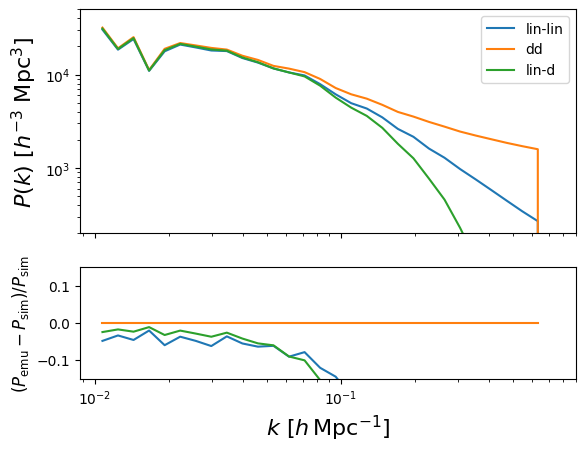

In [74]:
labels = ['lin-lin', 'dd', 'lin-d']
i_fid = 1

pk_objs = pk_objs_lagind

fig, axarr = plt.subplots(2, 1, sharex=True, height_ratios=[2, 1])
ax, ax1 = axarr
for i, pk_obj in enumerate(pk_objs):
    ax.plot(pk_obj['k'], pk_obj['pk'], label=labels[i])
    ax1.plot(pk_obj['k'], (pk_obj['pk']-pk_objs[i_fid]['pk'])/pk_objs[i_fid]['pk'])      
ax.set_xscale('log')
ax.set_yscale('log')


axarr[-1].set_xlabel(r'$k \,\, [h\,{\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=12)

ax.legend()
ax.set_ylim(2e2, 5e4)
ax1.set_ylim(-0.15, 0.15)

In [75]:
pairs = [[dens_lin_fromlpt, dens_lin_fromlpt], 
         [bias_term_eul_delta_raw_lagind, bias_term_eul_delta_raw_lagind],
         [dens_lin_fromlpt, bias_term_eul_delta_raw_lagind]]
pk_objs_raw_lagind = []
for pair in pairs:
    pk_obj = bacco.statistics.compute_crossspectrum_twogrids(
                            grid1=pair[0]/norm,
                            grid2=pair[1]/norm,
                            cosmology=cosmo_quijote,
                            ngrid=n_grid,
                            box=box_size,
                            normalise_grid1=normalise_grid,
                            normalise_grid2=normalise_grid,
                            deconvolve_grid1=deconvolve_grid,
                            deconvolve_grid2=deconvolve_grid,
                            **args_power)
    pk_objs_raw_lagind.append(pk_obj)

2024-08-16 17:08:55,795 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.01429e-11 (grid1) -1.01429e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.337787 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.470342 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000510 secs
bacco.power : Deallocating arrays


2024-08-16 17:09:02,621 bacco.statistics :  ...done in 6.83 s
2024-08-16 17:09:04,661 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -4.33315e-10 (grid1) -4.33315e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.390512 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.353173 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000477 secs
bacco.power : Deallocating arrays


2024-08-16 17:09:11,402 bacco.statistics :  ...done in 6.74 s
2024-08-16 17:09:13,083 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.01429e-11 (grid1) -4.33315e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.564852 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.390159 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000413 secs
bacco.power : Deallocating arrays


2024-08-16 17:09:20,087 bacco.statistics :  ...done in 7.0 s


/tmp/ipykernel_266602/3212884568.py:10: RuntimeWarning: invalid value encountered in divide
  ax1.plot(pk_obj['k'], (pk_obj['pk']-pk_objs[i_fid]['pk'])/pk_objs[i_fid]['pk'])


(-0.15, 0.15)

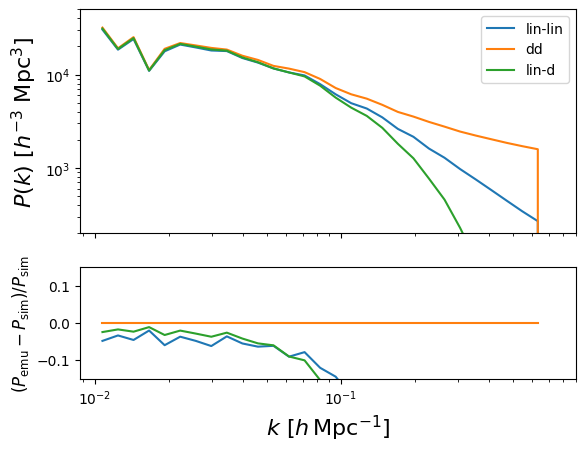

In [76]:
labels = ['lin-lin', 'dd', 'lin-d']
i_fid = 1

pk_objs = pk_objs_raw_lagind

fig, axarr = plt.subplots(2, 1, sharex=True, height_ratios=[2, 1])
ax, ax1 = axarr
for i, pk_obj in enumerate(pk_objs):
    ax.plot(pk_obj['k'], pk_obj['pk'], label=labels[i])
    ax1.plot(pk_obj['k'], (pk_obj['pk']-pk_objs[i_fid]['pk'])/pk_objs[i_fid]['pk'])      
ax.set_xscale('log')
ax.set_yscale('log')


axarr[-1].set_xlabel(r'$k \,\, [h\,{\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=12)

ax.legend()
ax.set_ylim(2e2, 5e4)
ax1.set_ylim(-0.15, 0.15)

### Check plots

In [32]:
n_grid = 512
pos_mesh = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos, 
                                         deposit_method='cic', interlacing=False)
pos_mesh = np.squeeze(pos_mesh)

2024-08-16 13:29:42,122 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-16 13:29:42,123 bacco.statistics : starting deposit 1
2024-08-16 13:29:43,254 bacco.statistics :  mesh done in 1.13 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


In [33]:
n_grid = 512
pos_mesh_raw = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos_raw, 
                                         deposit_method='cic', interlacing=False)
pos_mesh_raw = np.squeeze(pos_mesh_raw)

2024-08-16 13:29:46,037 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-16 13:29:46,039 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb


2024-08-16 13:29:47,148 bacco.statistics :  mesh done in 1.11 s


bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


In [34]:
n_grid = 512
pos_mesh_raword = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos_raword, 
                                         deposit_method='cic', interlacing=False)
pos_mesh_raword = np.squeeze(pos_mesh_raword)

2024-08-16 13:29:48,777 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-16 13:29:48,779 bacco.statistics : starting deposit 1
2024-08-16 13:29:49,989 bacco.statistics :  mesh done in 1.21 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


0.0 1313.9652
0.0 1313.9652
(512, 512, 512)
(512, 512)


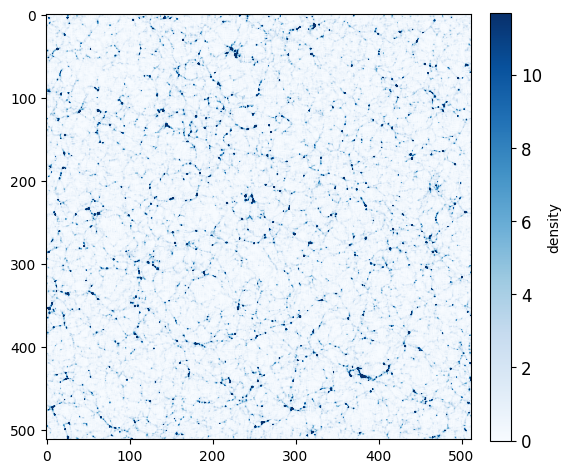

In [ ]:
plotter.plot_field(pos_mesh, overdensity=False)

0.0 1313.9601
0.0 1313.9601
(512, 512, 512)
(512, 512)


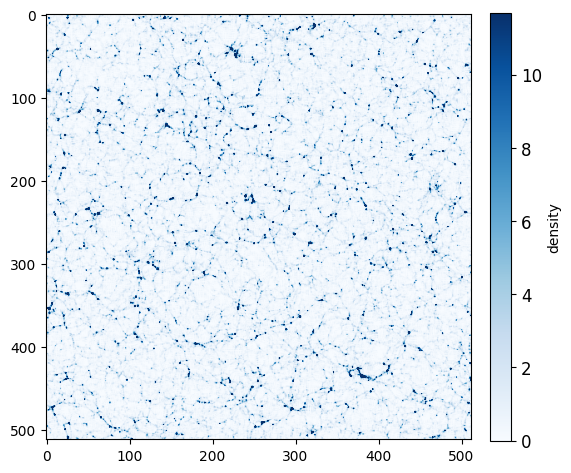

In [ ]:
plotter.plot_field(pos_mesh_raw, overdensity=False)

0.0 1313.9615
0.0 1313.9615
(512, 512, 512)
(512, 512)


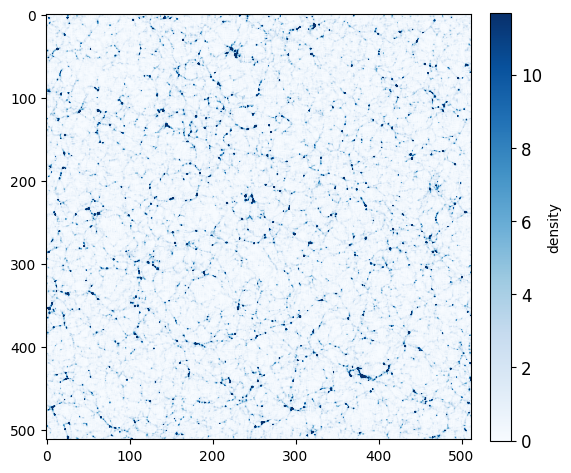

In [ ]:
plotter.plot_field(pos_mesh_raword, overdensity=False)

-15.754271507263184 14.615114212036133
-15.754271507263184 14.615114212036133
(512, 512, 512)
(512, 512)


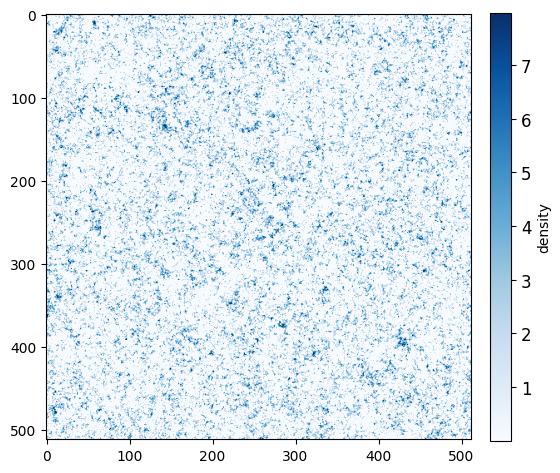

In [ ]:
plotter.plot_field(dens_lin_fromlpt, overdensity=False)

-15.754271507263184 14.615114212036133
-15.754271507263184 14.615114212036133
(512, 512, 512)
(512, 512)


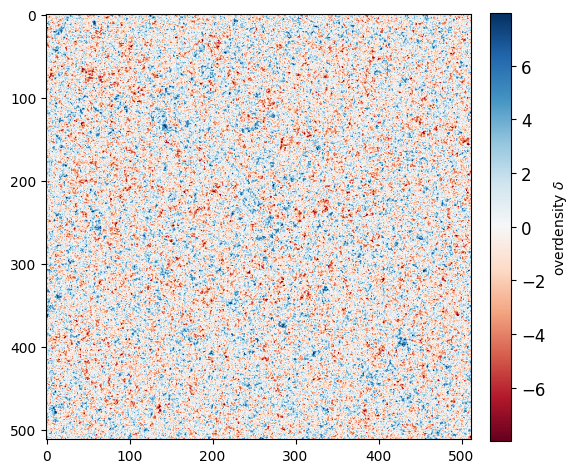

In [ ]:
plotter.plot_field(lin_field, overdensity=True)

-15.754271507263184 14.615114212036133
-15.754271507263184 14.615114212036133
(512, 512, 512)
(512, 512)


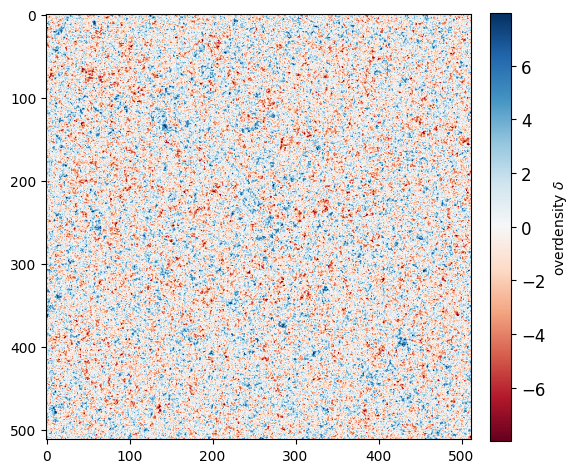

In [ ]:
plotter.plot_field(lin_field_lagind, overdensity=True)

### check pos

In [ ]:
diff = pos - pos_raword
diff = (diff + box_size/2) % box_size - box_size/2

In [ ]:
np.min(diff), np.max(diff)

(-500.0, 500.0)

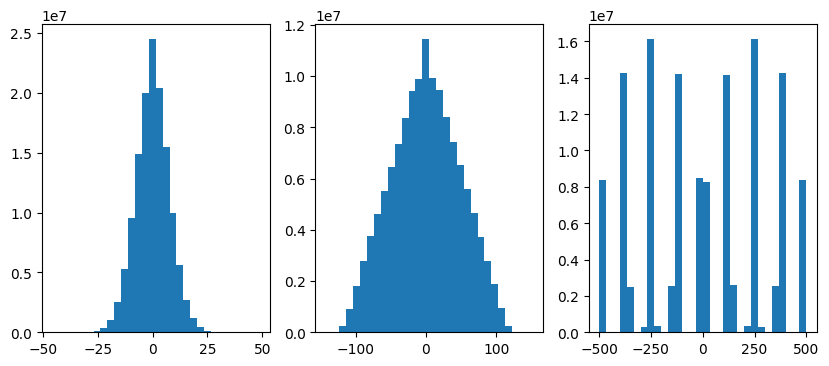

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,4))
for axis in range(3):
    ax[axis].hist(diff[:,axis],ls=':',#range=[-20,20], 
                  bins=30)

In [ ]:
diff = pos - pos_raw_lagind
diff = (diff + box_size/2) % box_size - box_size/2

In [ ]:
diff

array([[6.1035156e-05, 0.0000000e+00, 6.1035156e-05],
       [6.1035156e-05, 0.0000000e+00, 6.1035156e-05],
       [6.1035156e-05, 0.0000000e+00, 6.1035156e-05],
       ...,
       [0.0000000e+00, 6.1035156e-05, 6.1035156e-05],
       [6.1035156e-05, 6.1035156e-05, 0.0000000e+00],
       [6.1035156e-05, 6.1035156e-05, 6.1035156e-05]], dtype=float32)

In [ ]:
np.min(diff), np.max(diff)

(-3.0517578e-05, 6.1035156e-05)

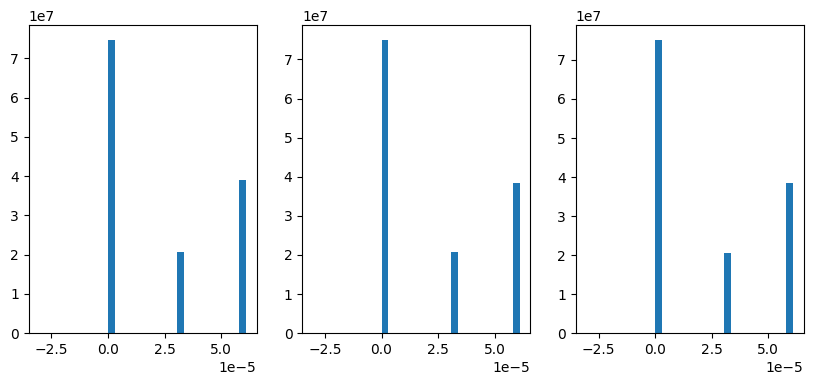

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,4))
for axis in range(3):
    ax[axis].hist(diff[:,axis],ls=':',#range=[-20,20], 
                  bins=30)

In [ ]:
diff = pos_raw - pos_raw_lagind
diff = (diff + box_size/2) % box_size - box_size/2

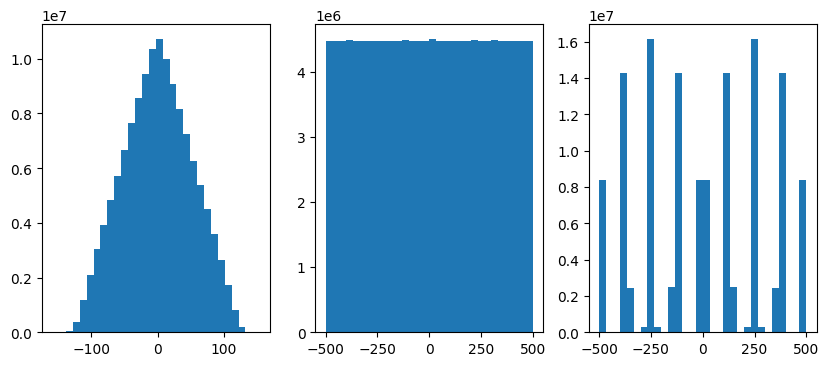

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,4))
for axis in range(3):
    ax[axis].hist(diff[:,axis],ls=':',#range=[-20,20], 
                  bins=30)

## Check ICs

#### From lpt

In [77]:
seed = int(idx_LH_str)
ngenic_phases = True 
phase_type = 1
z_start = 127
expfactor_start = (1/(1+z_start))
FixedInitialAmplitude = False
cosmo_quijote_start = utils.get_cosmo(param_dict, a_scale=expfactor_start)

sim_ics, disp_fromlpt_ics = bacco.utils.create_lpt_simulation(cosmo_quijote_start, box_size, Nmesh=n_grid, Seed=seed,
                                                    FixedInitialAmplitude=FixedInitialAmplitude,InitialPhase=0, 
                                                    expfactor=expfactor_start, LPT_order=2, order_by_order=None,
                                                    phase_type=phase_type, ngenic_phases=ngenic_phases, return_disp=True, 
                                                    sphere_mode=0)

2024-08-16 17:09:46,808 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2024-08-16 17:09:46,809 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
2024-08-16 17:09:46,809 bacco.sims : Initialising simulation Default
2024-08-16 17:09:46,810 bacco.sims : ...done in 0.00111 s


Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value
bacco.lss_scaler : 293 P(k) values; Di = (0.009866, 0.000097, 0.000001, 0.000001); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler: Computing 2LPT density...
l2=7.78209e-18 
l2=6.73432e-17 
l2=-3.85992e-17 
l2=-3.25662e-18 
l2=-4.83533e-17 
l2=-1.04182e-16 
bacco.lss_scaler: Fourier transforming second order source...
l2=-2.14218e-08 l3a=3.10621e-08 l3b=4.35151e-08


2024-08-16 17:10:14,834 bacco.scaler : Adding displacement field with a vel-factor=642.295853


bacco.lss_scaler:  Adding LSS displacement: vel_factor=642.295853 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [78]:
grid = bacco.visualization.uniform_grid(npix=n_grid, L=box_size, ndim=3, bounds=False)

pos_ics_fromlpt = bacco.scaler.add_displacement(None,
                                disp_fromlpt_ics,
                                box=box_size,
                                pos=grid.reshape(-1,3),
                                vel=None,
                                vel_factor=0,
                                verbose=False)[0]

In [120]:
seed = int(idx_LH_str)
ngenic_phases = True 
phase_type = 1
z_start = 127
expfactor_start = (1/(1+z_start))
FixedInitialAmplitude = False
cosmo_quijote_start = utils.get_cosmo(param_dict, a_scale=expfactor_start)

sim_ics_1lpt, disp_fromlpt_ics_1lpt = bacco.utils.create_lpt_simulation(cosmo_quijote_start, box_size, Nmesh=n_grid, Seed=seed,
                                                    FixedInitialAmplitude=FixedInitialAmplitude,InitialPhase=0, 
                                                    expfactor=expfactor_start, LPT_order=1, order_by_order=None,
                                                    phase_type=phase_type, ngenic_phases=ngenic_phases, return_disp=True, 
                                                    sphere_mode=0)

2024-08-16 17:48:27,855 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2024-08-16 17:48:27,856 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
2024-08-16 17:48:27,857 bacco.sims : Initialising simulation Default
2024-08-16 17:48:27,857 bacco.sims : ...done in 0.00127 s


Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value
bacco.lss_scaler : 293 P(k) values; Di = (0.009866, 0.000097, 0.000001, 0.000001); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


2024-08-16 17:48:42,681 bacco.scaler : Adding displacement field with a vel-factor=642.295853


bacco.lss_scaler:  Adding LSS displacement: vel_factor=642.295853 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [121]:
grid = bacco.visualization.uniform_grid(npix=n_grid, L=box_size, ndim=3, bounds=False)

pos_ics_fromlpt_1lpt = bacco.scaler.add_displacement(None,
                                disp_fromlpt_ics_1lpt,
                                box=box_size,
                                pos=grid.reshape(-1,3),
                                vel=None,
                                vel_factor=0,
                                verbose=False)[0]

In [135]:
seed = int(idx_LH_str)
ngenic_phases = True 
phase_type = 1
z_start = 127
expfactor_start = (1/(1+z_start))
FixedInitialAmplitude = False
cosmo_quijote_start = utils.get_cosmo(param_dict, a_scale=expfactor_start)

sim_ics_1lpt_damp, disp_fromlpt_ics_1lpt_damp = bacco.utils.create_lpt_simulation(cosmo_quijote_start, box_size, Nmesh=n_grid, Seed=seed,
                                                    FixedInitialAmplitude=FixedInitialAmplitude,InitialPhase=0, 
                                                    expfactor=expfactor_start, LPT_order=1, order_by_order=None,
                                                    phase_type=phase_type, ngenic_phases=ngenic_phases, return_disp=True, 
                                                    sphere_mode=0)

2024-08-16 18:10:45,195 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2024-08-16 18:10:45,196 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
2024-08-16 18:10:45,196 bacco.sims : Initialising simulation Default
2024-08-16 18:10:45,197 bacco.sims : ...done in 0.00137 s


Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value
damping_scale: 10000.0
bacco.lss_scaler : 293 P(k) values; Di = (0.009866, 0.000097, 0.000001, 0.000001); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


2024-08-16 18:11:00,422 bacco.scaler : Adding displacement field with a vel-factor=642.295853


bacco.lss_scaler:  Adding LSS displacement: vel_factor=642.295853 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [140]:
np.allclose(disp_fromlpt_ics_1lpt, disp_fromlpt_ics_1lpt_damp)

True

In [136]:
grid = bacco.visualization.uniform_grid(npix=n_grid, L=box_size, ndim=3, bounds=False)

pos_ics_fromlpt_1lpt_damp = bacco.scaler.add_displacement(None,
                                disp_fromlpt_ics_1lpt_damp,
                                box=box_size,
                                pos=grid.reshape(-1,3),
                                vel=None,
                                vel_factor=0,
                                verbose=False)[0]

#### From snapshot

In [37]:
import readgadget

# input files
# snapshot = '/home/fvillaescusa/Quijote/Snapshots/h_p/snapdir_002/snap_002'
snapshot_ics = '/dipc/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/663/ICs/ics'
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

# read positions, velocities and IDs of the particles
pos_ics_raw = readgadget.read_block(snapshot_ics, "POS ", ptype)/1e3 #positions in Mpc/h
ids_ics = readgadget.read_block(snapshot_ics, "ID  ", ptype)-1   #IDs starting from 0

In [58]:
pos_ics_raw_lagind = pos_ics_raw[lag_index_ics]

In [64]:
pos_ics_raword_lagind = pos_ics_raw[ids_ics][lag_index]

#### Compare

In [79]:
diff = pos_ics_fromlpt - pos_ics_raw_lagind
diff = (diff + box_size/2) % box_size - box_size/2

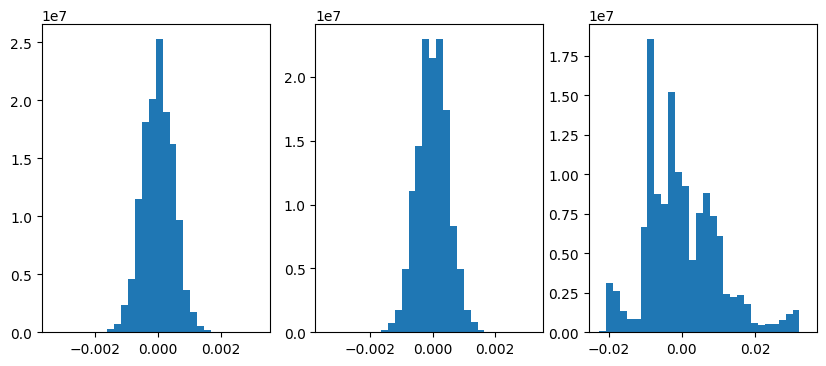

In [80]:
fig, ax = plt.subplots(1,3, figsize=(10,4))
for axis in range(3):
    ax[axis].hist(diff[:,axis],ls=':',#range=[-20,20], 
                  bins=30)

In [81]:
diff = pos_ics_fromlpt - pos_ics_raword_lagind
diff = (diff + box_size/2) % box_size - box_size/2

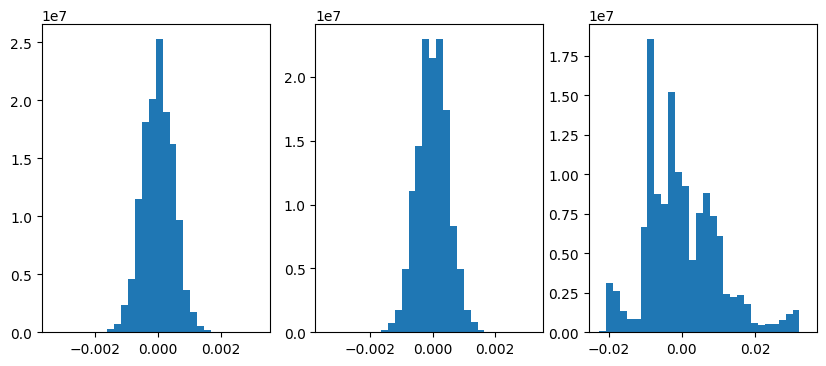

In [82]:
fig, ax = plt.subplots(1,3, figsize=(10,4))
for axis in range(3):
    ax[axis].hist(diff[:,axis],ls=':',#range=[-20,20], 
                  bins=30)

In [122]:
diff = pos_ics_fromlpt - pos_ics_fromlpt_1lpt
diff = (diff + box_size/2) % box_size - box_size/2

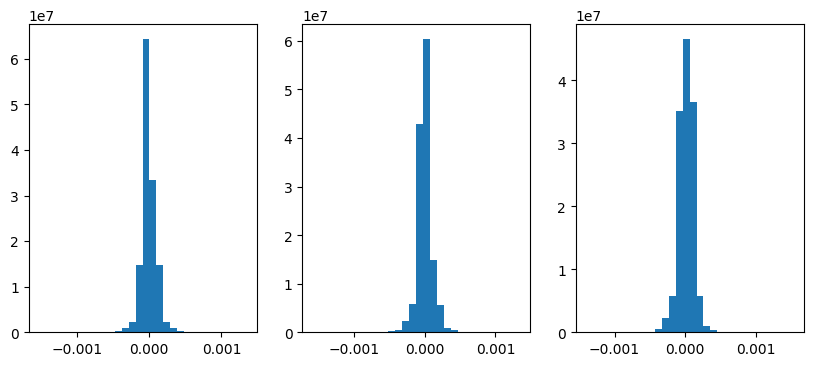

In [123]:
fig, ax = plt.subplots(1,3, figsize=(10,4))
for axis in range(3):
    ax[axis].hist(diff[:,axis],ls=':',#range=[-20,20], 
                  bins=30)

In [124]:
diff = pos_ics_fromlpt_1lpt - pos_ics_raw_lagind
diff = (diff + box_size/2) % box_size - box_size/2

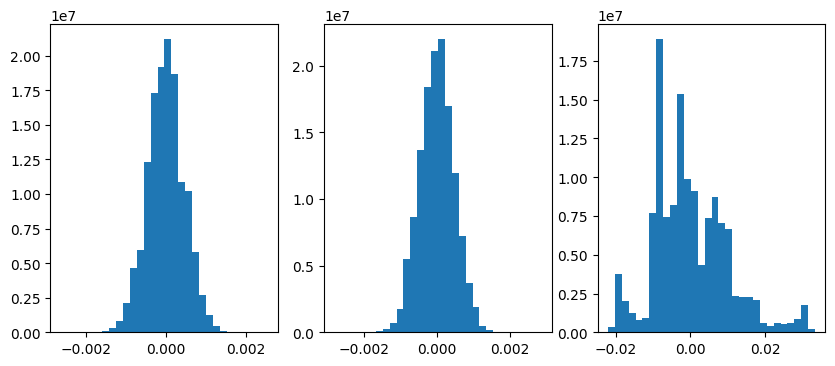

In [125]:
fig, ax = plt.subplots(1,3, figsize=(10,4))
for axis in range(3):
    ax[axis].hist(diff[:,axis],ls=':',#range=[-20,20], 
                  bins=30)

In [137]:
diff = pos_ics_fromlpt_1lpt - pos_ics_fromlpt_1lpt_damp
diff = (diff + box_size/2) % box_size - box_size/2

In [139]:
np.min(diff), np.max(diff)

(0.0, 0.0)

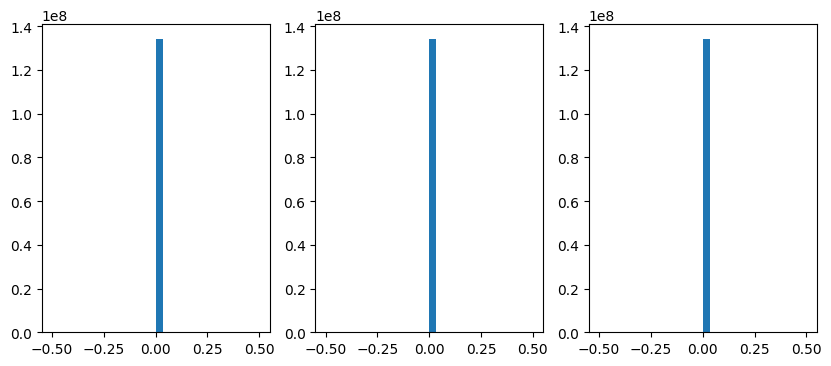

In [138]:
fig, ax = plt.subplots(1,3, figsize=(10,4))
for axis in range(3):
    ax[axis].hist(diff[:,axis],ls=':',#range=[-20,20], 
                  bins=30)

In [86]:
#let's compute the ZA displacement field
q = bacco.visualization.uniform_grid(npix=n_grid, L=sim.header['BoxSize'], ndim=3, bounds=False)

pp_ics = pos_ics_raword_lagind

print(np.min(pp_ics), np.max(pp_ics))
print(np.min(q), np.max(q))

1.08638005e-07 1000.0
0.0 998.0469


In [87]:
disp_za = pp_ics - q.reshape(n_grid**3,3)
disp_za_wrap = (disp_za + box_size/2) % box_size - box_size/2
# disp_za[np.where(disp_za>sim.header['BoxSize']/2.0)]  -= sim.header['BoxSize']
# disp_za[np.where(disp_za<-sim.header['BoxSize']/2.0)] += sim.header['BoxSize']

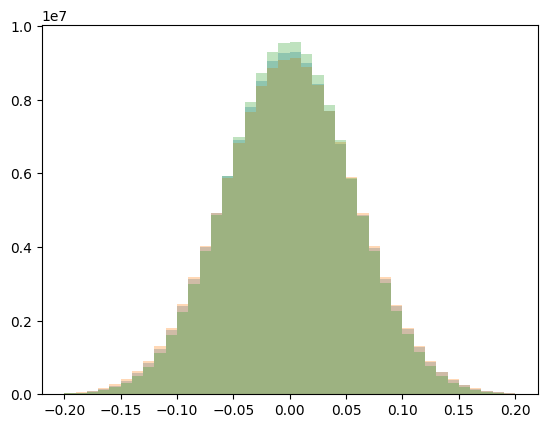

In [89]:
for i in range(3):
    plt.hist(disp_za_wrap[:,i],bins=40, range=[-0.2,0.2], alpha=0.3)

In [90]:
np.min(disp_za_wrap), np.max(disp_za_wrap)

(-0.31207275, 0.31661987)

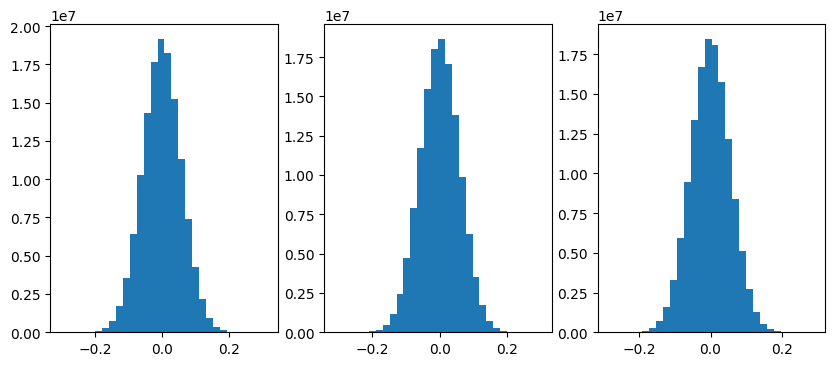

In [91]:
fig, ax = plt.subplots(1,3, figsize=(10,4))
for axis in range(3):
    ax[axis].hist(disp_za_wrap[:,axis],ls=':',#range=[-20,20], 
                  bins=30)

In [95]:
disp_fromlpt_ics.shape, disp_za.shape

((3, 512, 512, 512), (134217728, 3))

In [126]:
sdisp_1lpt = disp_fromlpt_ics_1lpt.reshape(3,n_grid**3).T
print(sdisp_1lpt.shape)
sdisp_2lpt = disp_fromlpt_ics.reshape(3,n_grid**3).T
print(sdisp_2lpt.shape)

(134217728, 3)
(134217728, 3)


In [127]:
im1_1lpt = sdisp_1lpt.reshape(n_grid,n_grid,n_grid,3)
print(im1_1lpt.shape)
im1_2lpt = sdisp_2lpt.reshape(n_grid,n_grid,n_grid,3)
print(im1_2lpt.shape)
im2 = disp_za_wrap.reshape(n_grid,n_grid,n_grid,3)
print(im2.shape)

(512, 512, 512, 3)
(512, 512, 512, 3)
(512, 512, 512, 3)


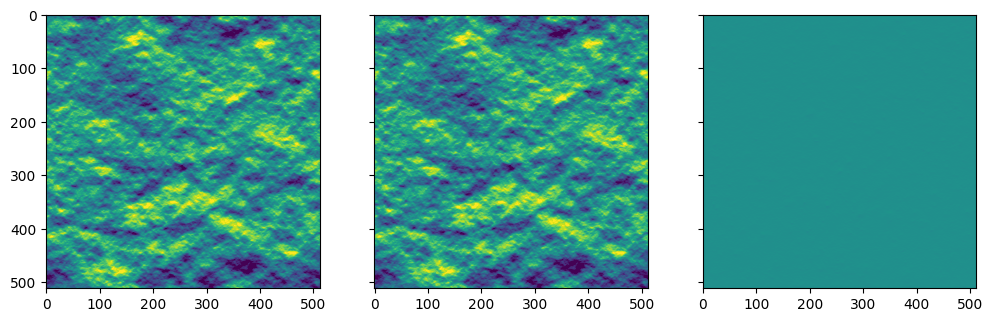

In [141]:
col, axis = 11, 0
fig, ax = plt.subplots(1,3, figsize=(12,5), sharex=True, sharey=True)
ax[0].imshow(im1_1lpt[:,:,col,axis], vmin=-0.15,vmax=0.15)
ax[1].imshow(im2[:,:,col,axis], vmin=-0.15,vmax=0.15)
ax[2].imshow(im2[:,:,col,axis]-im1_1lpt[:,:,col,axis], 
             vmin=-0.015,vmax=0.015
             #vmin=-0.0015,vmax=0.0015
             )

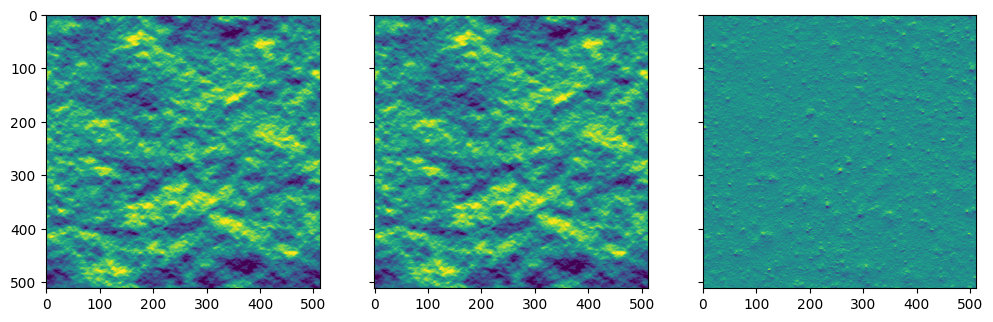

In [117]:
col, axis = 11, 0
fig, ax = plt.subplots(1,3, figsize=(12,5), sharex=True, sharey=True)
ax[0].imshow(im1_2lpt[:,:,col,axis], vmin=-0.15,vmax=0.15)
ax[1].imshow(im2[:,:,col,axis], vmin=-0.15,vmax=0.15)
ax[2].imshow(im2[:,:,col,axis]-im1_2lpt[:,:,col,axis], 
             #vmin=-0.015,vmax=0.015
             vmin=-0.0015,vmax=0.0015
             )

In [129]:
for axis in np.arange(3):
    print("Stdev between BACCO and QUIJOTE's ICs:",np.std(im1_1lpt[...,axis]-im2[...,axis]))
    print("2lpt:",np.std(im1_2lpt[...,axis]-im2[...,axis]))


Stdev between BACCO and QUIJOTE's ICs: 0.00045605906
2lpt: 0.00048742583
Stdev between BACCO and QUIJOTE's ICs: 0.00045760206
2lpt: 0.00048885384
Stdev between BACCO and QUIJOTE's ICs: 0.009932152
2lpt: 0.0099337045


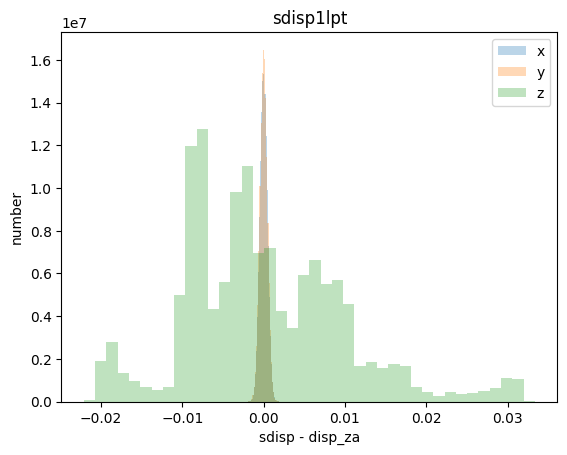

In [144]:
#plt.hist(sdisp_2lpt[:,0]-sdisp[:,0])
plt.title('sdisp1lpt')
myrange = None
#myrange = [-0.01,0.01]
plt.hist(sdisp_1lpt[:,0]-disp_za_wrap[:,0],bins=40, range=myrange, alpha=0.3, label='x')
plt.hist(sdisp_1lpt[:,1]-disp_za_wrap[:,1],bins=40, range=myrange, alpha=0.3, label='y')
plt.hist(sdisp_1lpt[:,2]-disp_za_wrap[:,2],bins=40, range=myrange, alpha=0.3, label='z')
plt.xlabel('sdisp - disp_za')
plt.ylabel('number')
plt.legend()

(array([   53068.,  1917154.,  2798567.,  1343978.,   971057.,   679311.,
          558751.,   691958.,  5006362., 11962501., 12747749.,  4346836.,
         5586586.,  9794793., 11045820.,  6972831.,  7173124.,  4252240.,
         3428597.,  5918916.,  6648312.,  5494922.,  5711293.,  4564557.,
         1687508.,  1865572.,  1557743.,  1775920.,  1676077.,   671484.,
          464095.,   271525.,   468716.,   350400.,   411174.,   502582.,
          623536.,  1113751.,  1074117.,    34245.]),
 array([-2.20931172e-02, -2.07071770e-02, -1.93212349e-02, -1.79352947e-02,
        -1.65493544e-02, -1.51634132e-02, -1.37774721e-02, -1.23915318e-02,
        -1.10055907e-02, -9.61965043e-03, -8.23370926e-03, -6.84776856e-03,
        -5.46182785e-03, -4.07588668e-03, -2.68994598e-03, -1.30400527e-03,
         8.19355264e-05,  1.46787637e-03,  2.85381707e-03,  4.23975801e-03,
         5.62569872e-03,  7.01163942e-03,  8.39758012e-03,  9.78352129e-03,
         1.11694615e-02,  1.25554027e-02,  1.3

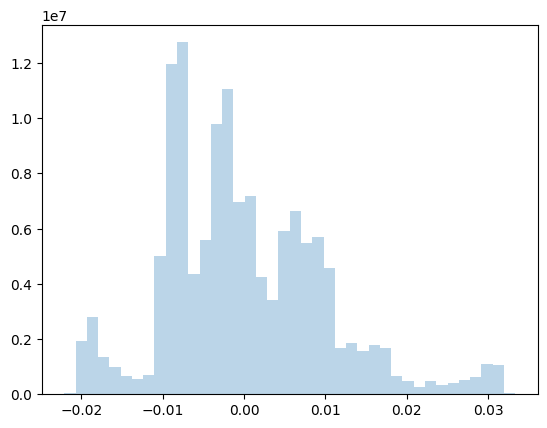

In [134]:
#plt.hist(sdisp_2lpt[:,0]-sdisp[:,0])
#plt.hist(sdisp_1lpt[:,0]-disp_za_wrap[:,0],bins=40, range=[-0.01,0.01], alpha=0.3)
#plt.hist(sdisp_1lpt[:,1]-disp_za_wrap[:,1],bins=40, range=[-0.01,0.01], alpha=0.3)
plt.hist(sdisp_1lpt[:,2]-disp_za_wrap[:,2],bins=40, 
         #range=[-0.01,0.01], 
         alpha=0.3)

Text(0, 0.5, 'number')

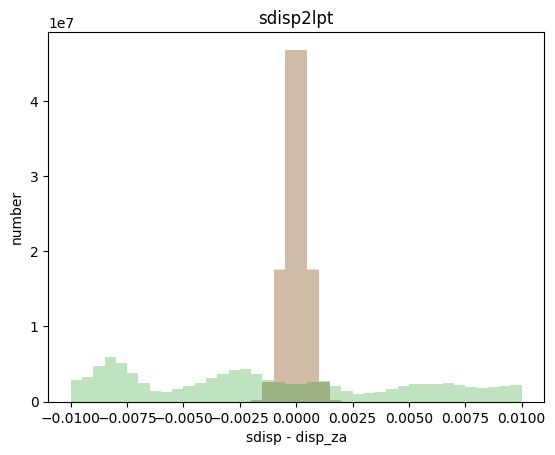

In [142]:
#plt.hist(sdisp_2lpt[:,0]-sdisp[:,0])
plt.title('sdisp2lpt')
plt.hist(sdisp_2lpt[:,0]-disp_za_wrap[:,0],bins=40, range=[-0.01,0.01], alpha=0.3, label='x')
plt.hist(sdisp_2lpt[:,1]-disp_za_wrap[:,1],bins=40, range=[-0.01,0.01], alpha=0.3, label='y')
plt.hist(sdisp_2lpt[:,2]-disp_za_wrap[:,2],bins=40, range=[-0.01,0.01], alpha=0.3, label='z')
plt.xlabel('sdisp - disp_za')
plt.ylabel('number')

In [41]:
ics_mesh_fromlpt = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos_ics_fromlpt, 
                                         deposit_method='cic', interlacing=False)
ics_mesh_fromlpt = np.squeeze(ics_mesh_fromlpt)

2024-08-16 13:31:37,784 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-16 13:31:37,785 bacco.statistics : starting deposit 1
2024-08-16 13:31:38,529 bacco.statistics :  mesh done in 0.746 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


In [48]:
ics_mesh_lagind = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos_ics_raword_lagind, 
                                         deposit_method='cic', interlacing=False)
ics_mesh_lagind = np.squeeze(ics_mesh_lagind)

2024-08-16 14:12:29,027 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-16 14:12:29,028 bacco.statistics : starting deposit 1
2024-08-16 14:12:30,053 bacco.statistics :  mesh done in 1.03 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


In [92]:
for axis in np.arange(3):
    print("Stdev between BACCO and QUIJOTE's ICs:",np.std(ics_mesh_fromlpt[...,axis]-ics_mesh_lagind[...,axis]))


Stdev between BACCO and QUIJOTE's ICs: 0.002111203
Stdev between BACCO and QUIJOTE's ICs: 0.0020993343
Stdev between BACCO and QUIJOTE's ICs: 0.002099202


0.8811857 1.183788
0.8811857 1.183788
(512, 512, 512)
(512, 512)


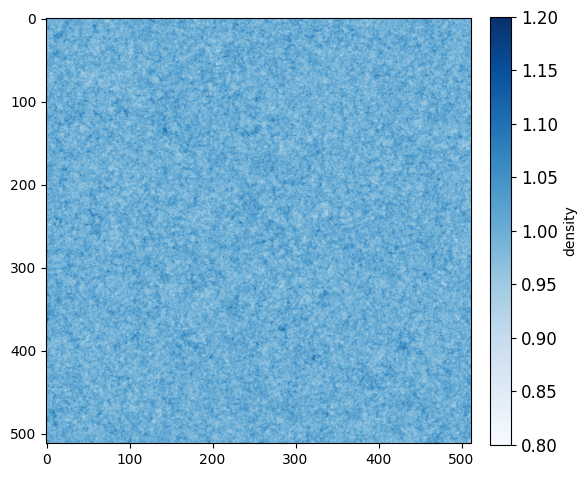

In [49]:
plotter.plot_field(ics_mesh_fromlpt, overdensity=False,
                   vmin=0.8, vmax=1.2)

0.8854248 1.1906669
0.8854248 1.1906669
(512, 512, 512)
(512, 512)


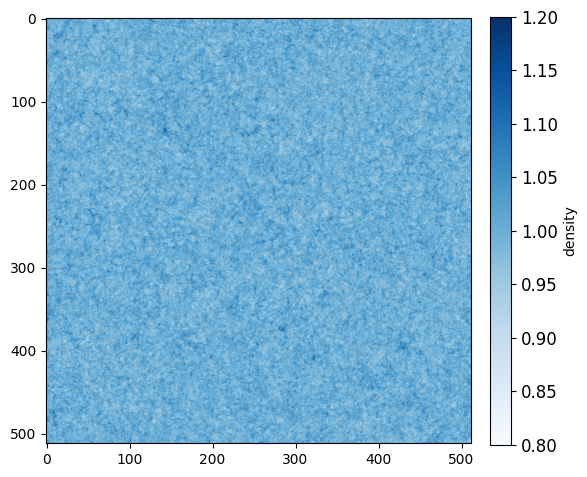

In [50]:
plotter.plot_field(ics_mesh_lagind, overdensity=False,
                   vmin=0.8, vmax=1.2)

-0.03303492 0.033269048
-0.03303492 0.033269048
(512, 512, 512)
(512, 512)


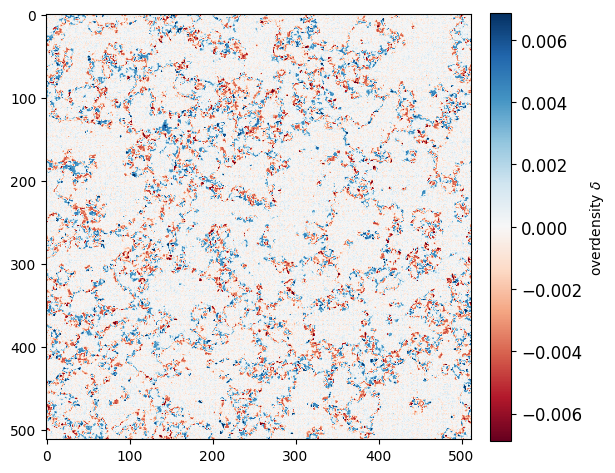

In [51]:
plotter.plot_field(ics_mesh_lagind - ics_mesh_fromlpt, overdensity=True,
                   #vmin=0.8, vmax=1.2
                   )

-0.03235848 0.033920154
-0.03235848 0.033920154
(512, 512, 512)
(512, 512)


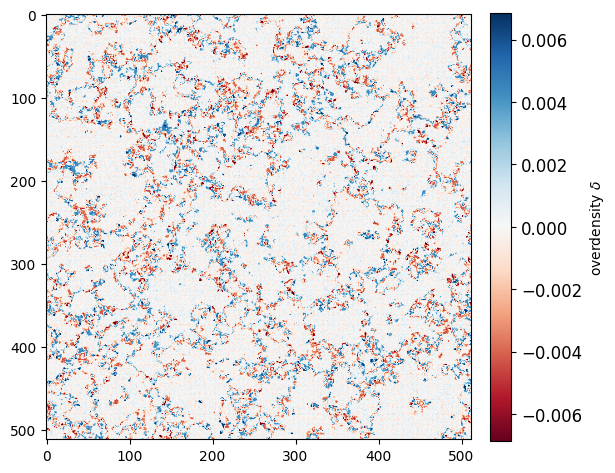

In [52]:
plotter.plot_field((ics_mesh_lagind - ics_mesh_fromlpt)/ics_mesh_fromlpt, overdensity=True,
                   #vmin=0.8, vmax=1.2
                   )